1. Завантаження та підготовка даних

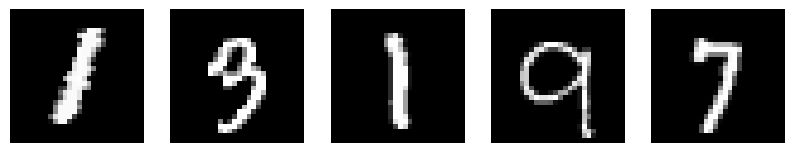

In [89]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

examples = iter(train_loader)
images, _ = next(examples)
fig, axes = plt.subplots(1, 5, figsize=(10, 2))

for i in range(5):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].axis('off')

plt.show()


2. Реалізація автоенкодера
Енкодер складається з 2 шарів: перетворення початкового 28х28 зображення у вектор розміром 128 та шару зменшення вектора зі 128 до 32. В обох випадках використовується функція октивації ReLU
Декодер теж складається з 2 шарів: перетворення вектора 32 у вектор 128 та шару відновлення вектора 128 у початкове зображення 28х28. В першому шарі використовується функція ReLU, а в другому сигмоїдна функція

In [5]:
import torch.nn as nn


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128), nn.ReLU(),
            nn.Linear(128, 28*28), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x


3. Навчання автоенкодера
Для навчання буде використано оптимізатор Адама та функцію втрат MSELoss(Mean Squared Error), буде проводено 10 епох навчання

In [6]:
import torch.optim as optim


model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    for images, _ in train_loader:
        images = images.view(-1, 28*28)
        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


4. Тестування автоенкодера
Для тестування автоенкодера нам потрібно отримати нову порцію даних, прогнати її через наш автоенкодер та порівняти отримані дані з початковими

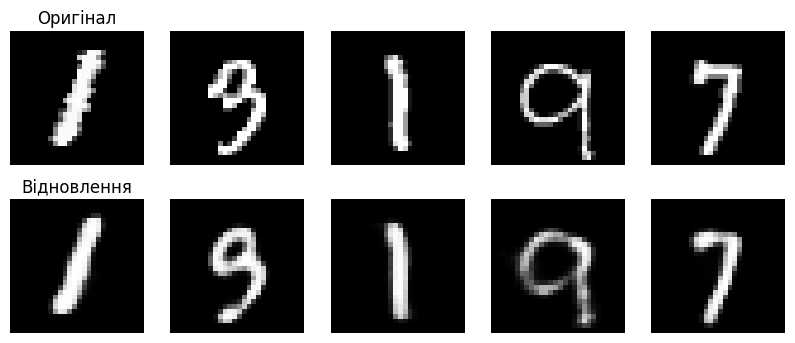

In [90]:
# Підготовка даних
images_flat = images.view(-1, 28*28)

# Проганяємо дані через модель
model.eval() 
with torch.no_grad():
    outputs = model(images_flat)

# Перетворюємо назад у форму зображень
outputs = outputs.view(-1, 1, 28, 28)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    # Оригінальне зображення
    axes[0, i].imshow(images[i].squeeze(), cmap="gray")
    axes[0, i].axis('off')

    # Відновлене зображення
    axes[1, i].imshow(outputs[i].squeeze(), cmap="gray")
    axes[1, i].axis('off')

axes[0, 0].set_title("Оригінал")
axes[1, 0].set_title("Відновлення")

plt.show()


5. Реалізація варіаційного автоенкодера (VAE)
Енкодер складається з 2 шарів: перетворення початкового 28х28 зображення у вектор розміром 128 та шару зменшення вектора зі 128 до 32. В обох випадках використовується функція октивації ReLU
Декодер складається з 3 шарів: перетворення вектора 16 у вектор 32, перетворення вектора 32 у 128 та шару відновлення вектора 128 у початкове зображення 28х28. В перших двох шарах використовується функція ReLU, а в третьому сигмоїдна функція
Окрім цього в цьому автоенкодері пристуній механізм для навчання розподілу латентного простору, зокрема, середнього значення mu та логарифму дисперсії logvar для кожного латентного вектору

In [17]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU()
        )
        self.fc_mu = nn.Linear(32, 16)
        self.fc_logvar = nn.Linear(32, 16)
        self.decoder = nn.Sequential(
            nn.Linear(16, 32), nn.ReLU(),
            nn.Linear(32, 128), nn.ReLU(),
            nn.Linear(128, 28*28), nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        
        return self.decoder(z), mu, logvar


6. Реалізація варіаційного автоенкодера (VAE)
Для навчання буде використано оптимізатор Адама та кастомна функція втрат, буде проводено 10 епох навчання

In [76]:
import torch.optim as optim


def loss_function(recon_x, x, mu, logvar):
    # Втрата реконструкції (MSE Loss)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # Втрата KL-дивергенції
    # KL-дивергенція між нормальним розподілом N(0, I) і латентним розподілом
    # Формула: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # де sigma = exp(0.5 * logvar)
    # Це забезпечує, щоб згенеровані латентні змінні не відхилялися сильно від стандартного нормального розподілу.
    # За допомогою `mu` та `logvar` можна обчислити KL-дивергенцію.
    # Для цього використовуємо функцію, що працює зі стандартним нормальним розподілом.
    
    # Обчислюємо KL-втрату:
    # Крок 1: обчислюємо sigma (стандартне відхилення)
    std = torch.exp(0.5 * logvar)
    
    # Крок 2: обчислюємо KL-дивергенцію
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - std.pow(2), dim=1)
    
    # Повертаємо загальну втрату:
    return BCE + kl_loss.mean()

v_model = VAE()
criterion = nn.MSELoss()
optimizer = optim.Adam(v_model.parameters(), lr=0.001)

for epoch in range(10):
    for images, _ in train_loader:
        images = images.view(-1, 28*28)
        recon_batch, mu, logvar = v_model(images)
        
        # Обчислюємо втрати
        loss = loss_function(recon_batch, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

7. Тестування автоенкодера
Для тестування автоенкодера нам потрібно отримати нову порцію даних, прогнати її через наш автоенкодер та порівняти отримані дані з початковими

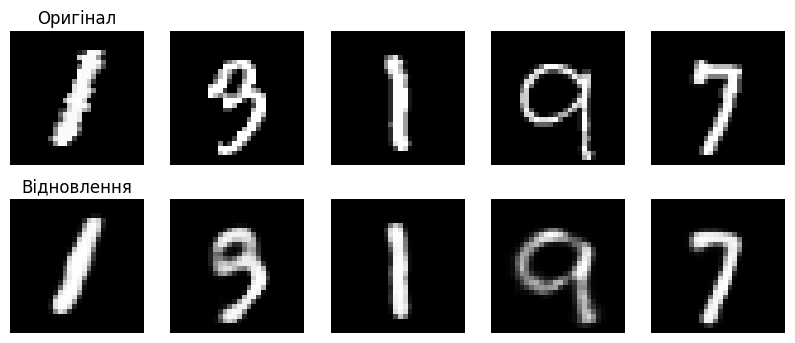

In [91]:
# Підготовка даних
images_flat = images.view(-1, 28*28)

# Проганяємо дані через модель
model.eval() 
with torch.no_grad():
    outputs, _, _ = v_model(images_flat)

# Перетворюємо назад у форму зображень
outputs = outputs.view(-1, 1, 28, 28)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    # Оригінальне зображення
    axes[0, i].imshow(images[i].squeeze(), cmap="gray")
    axes[0, i].axis('off')

    # Відновлене зображення
    axes[1, i].imshow(outputs[i].squeeze(), cmap="gray")
    axes[1, i].axis('off')

axes[0, 0].set_title("Оригінал")
axes[1, 0].set_title("Відновлення")

plt.show()

Контрольні питання
1. У чому відмінність класичного автоенкодера від варіаційного (VAE)?

Класичний автоенкодер стискає дані в латентне представлення без урахування ймовірнісної природи — він кодує вхід у фіксовану точку латентного простору. Натомість VAE використовує ймовірнісний підхід: енкодер виводить параметри розподілу (зазвичай середнє та дисперсію), з якого потім семплюється латентна змінна. Це дозволяє VAE генерувати нові дані, що робить його більш придатним для генеративних завдань.

2. Як вибір латентного простору впливає на якість реконструкції?

Розмір та структура латентного простору прямо впливають на здатність моделі кодувати суттєві особливості вхідних даних. Занадто малий простір може не вміщати достатньо інформації, що веде до втрати деталей і поганої реконструкції. Навпаки, надто великий або занадто гнучкий простір може призвести до перенавчання — модель почне запам’ятовувати вхідні приклади замість узагальнення, що теж знижує якість результатів.

3. Чому в VAE використовується KL-дивергенція?

KL-дивергенція в VAE — це регуляризатор, що змушує латентні розподіли бути близькими до заданого апостеріорного (зазвичай стандартного нормального) розподілу. Це підтримує впорядкованість та неперервність латентного простору, завдяки чому модель може адекватно генерувати нові зразки навіть з незнайомих точок простору. Вона також запобігає тому, щоб модель просто запам’ятовувала приклади, сприяючи узагальненню.

4. Де в реальному житті застосовуються автоенкодери?

Автоенкодери знаходять застосування в багатьох галузях:

    У комп’ютерному зорі — для стиснення зображень, усунення шуму (denoising), покращення якості.

    У системах рекомендацій — для зниження розмірності та виявлення схожих користувачів або продуктів.

    У виявленні аномалій — коли модель навчається на "нормальних" даних, вона може сигналізувати про відхилення у разі незвичних входів (наприклад, у фінансовому моніторингу чи кібербезпеці).

5. Як можна покращити якість генерації у VAE?

Якість генерації можна покращити кількома способами:

    Збільшення розміру латентного простору, щоб модель мала більше можливостей кодувати важливу інформацію.

    Ускладнення архітектури мережі — додавання шарів або використання більш потужних блоків (наприклад, CNN, ResNet) дозволяє краще моделювати складну структуру вхідних даних.

    Використання покращених варіантів VAE, таких як β-VAE або VQ-VAE, які краще контролюють компроміс між реконструкцією і генерацією.

    Тюнінг гіперпараметрів, включаючи вагу KL-дивергенції, тип активаційних функцій і вибір оптимізатора.